Here we compare the results of the gmprocess command with NGA West 2 on strong motion data from two earthquakes:
 - Coalinga 1983
 - Parkfield 2004
 
The peak ground motion data has been pre-processed from raw data available from CESMD.

In [12]:
%matplotlib inline

Import non-gmprocess dependencies

In [1]:
# stdlib imports
import re
import os.path
import json

# third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pkg_resources

The two files defined below contain the NGA West 2 flatfile database of recorded ground motions, and then the gmprocess-derived results for the Coalinga 1983 and Parkfield 2004 events.

In [5]:
dataroot = pkg_resources.resource_filename('gmprocess','data')

nga_file = os.path.join(dataroot,'nga_west2_reduced.xlsx')
nga_frame = pd.read_excel(nga_file, na_values=-999)

gmp_file = os.path.join(dataroot,'rotd50.0.xlsx')
gmp_frame = pd.read_excel(gmp_file)

To re-process the data from these two earthquakes, follow the gmprocess installation instructions, then run the following two commands (assuming you are in the directory where this notebook is located):

`find . -name '*.hdf' -exec rm {} \;`

`gmprocess --directory=. --assemble --process --report --provenance --export --format excel -o . --config custom_config.yml`

Define a function to extract a merged dataframe with cells from the NGA flatfile and the results from gmprocess.

In [6]:
def get_merge_frame(nga_frame, gmp_frame, nga_id, comcat_id):
    # what are the columns we want to sub-select from the two frames?
    ngacols = ['Station ID  No.','PGA (g)', 'PGV (cm/sec)', 'T1.000S', 'T3.000S']
    gmpcols = ['StationCode', 'PGA', 'PGV', 'SA(1.000)','SA(3.000)']
    # select just the rows matching the input IDs
    nga_event = nga_frame[nga_frame['EQID'] == nga_id]
    gmp_event = gmp_frame[gmp_frame['EarthquakeId'] == comcat_id]
    
    # reduce the columns using the lists above
    nga_reduced = nga_event[ngacols]
    gmp_reduced = gmp_event[gmpcols]
    
    # rename the NGA Station column so we can merge the two frames
    nga_reduced = nga_reduced.rename(columns={'Station ID  No.':'StationCode'})
    
    # merge the frames
    merge_frame = nga_reduced.merge(gmp_reduced)
    return merge_frame

Define a function to take the merged frame and create a multi-panel plot comparing NGA results to gmprocess results.

In [7]:
def merge_plot(merge_frame):
        
    fig, axeslist = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
    ORANGE = np.array([214, 102, 3])/255.0

    nga_pgv = merge_frame['PGV (cm/sec)']
    gmp_pgv = merge_frame['PGV']
    dmin = min(np.nanmin(nga_pgv),np.nanmin(gmp_pgv))
    dmax = max(np.nanmax(nga_pgv),np.nanmax(gmp_pgv))
    ext = np.array([dmin,dmax])
    axeslist[0,0].plot(ext, ext,'k');
    axeslist[0,0].plot(nga_pgv, gmp_pgv, color=ORANGE,marker='.',linestyle='None', markersize=12);
    axeslist[0,0].plot(ext, ext*1.1,'0.5', linestyle='--');
    axeslist[0,0].plot(ext, ext/1.1,'0.5', linestyle='--');
    axeslist[0,0].set_xlim([dmin,dmax]);
    axeslist[0,0].set_ylim([dmin,dmax]);
    axeslist[0,0].set_xlabel('NGA PGV');
    axeslist[0,0].set_ylabel('GMP PGV');
    axeslist[0,0].set_aspect('equal', 'datalim')

    nga_pga = merge_frame['PGA (g)']
    gmp_pga = merge_frame['PGA']/100 # GMP accelerations in %g
    dmin = min(np.nanmin(nga_pga),np.nanmin(gmp_pga))
    dmax = max(np.nanmax(nga_pga),np.nanmax(gmp_pga))
    ext = np.array([dmin,dmax])
    axeslist[0,1].plot(ext, ext,'k');
    axeslist[0,1].plot(nga_pga, gmp_pga, color=ORANGE,marker='.',linestyle='None', markersize=12);
    axeslist[0,1].plot(ext, ext*1.1,'0.5', linestyle='--');
    axeslist[0,1].plot(ext, ext/1.1,'0.5', linestyle='--');
    axeslist[0,1].set_xlabel('NGA PGA');
    axeslist[0,1].set_ylabel('GMP PGA');

    nga_psa1 = merge_frame['T1.000S']
    gmp_psa1 = merge_frame['SA(1.000)']/100 # GMP accelerations in %g
    dmin = min(np.nanmin(nga_psa1),np.nanmin(gmp_psa1))
    dmax = max(np.nanmax(nga_psa1),np.nanmax(gmp_psa1))
    ext = np.array([dmin,dmax])
    axeslist[1,0].plot(ext, ext,'k');
    axeslist[1,0].plot(nga_psa1, gmp_psa1, color=ORANGE,marker='.',linestyle='None', markersize=12);
    axeslist[1,0].plot(ext, ext*1.1,'0.5', linestyle='--');
    axeslist[1,0].plot(ext, ext/1.1,'0.5', linestyle='--');
    axeslist[1,0].set_xlabel('NGA SA(1.0)');
    axeslist[1,0].set_ylabel('GMP SA(1.0)');

    nga_psa3 = merge_frame['T3.000S']
    gmp_psa3 = merge_frame['SA(3.000)']/100 # GMP accelerations in %g
    dmin = min(np.nanmin(nga_psa3),np.nanmin(gmp_psa3))
    dmax = max(np.nanmax(nga_psa3),np.nanmax(gmp_psa3))
    ext = np.array([dmin,dmax])
    axeslist[1,1].plot(ext, ext,'k');
    axeslist[1,1].plot(nga_psa3, gmp_psa3, color=ORANGE,marker='.',linestyle='None', markersize=12);
    axeslist[1,1].plot(ext, ext*1.1,'0.5', linestyle='--');
    axeslist[1,1].plot(ext, ext/1.1,'0.5', linestyle='--');
    axeslist[1,1].set_xlabel('NGA SA(3.0)');
    axeslist[1,1].set_ylabel('GMP SA(3.0)');

    plt.tight_layout()

Merge the results from Coalinga

In [8]:
coalinga_nga_id = 76
coalinga_comcat_id = 'nc1091100'
coalinga_merge = get_merge_frame(nga_frame, gmp_frame, 
                                 coalinga_nga_id,
                                 coalinga_comcat_id)
coalinga_merge.head()

,StationCode,PGA (g),PGV (cm/sec),T1.000S,T3.000S,PGA,PGV,SA(1.000),SA(3.000)
0,46314,0.269530,26.2130,0.366067,0.077963,26.821259,26.067549,36.588400,7.859180
1,36228,0.110290,10.5250,0.145429,0.021890,11.013700,10.502915,14.578701,2.204241
2,36451,0.121470,10.4500,0.109935,0.015588,12.195447,10.336166,11.016677,1.635839
3,36226,0.098653,9.0145,0.086403,0.017964,9.845985,9.090094,8.679355,1.838038
4,36407,0.122290,19.0460,0.361514,0.071307,12.149950,18.859776,36.318865,7.185615


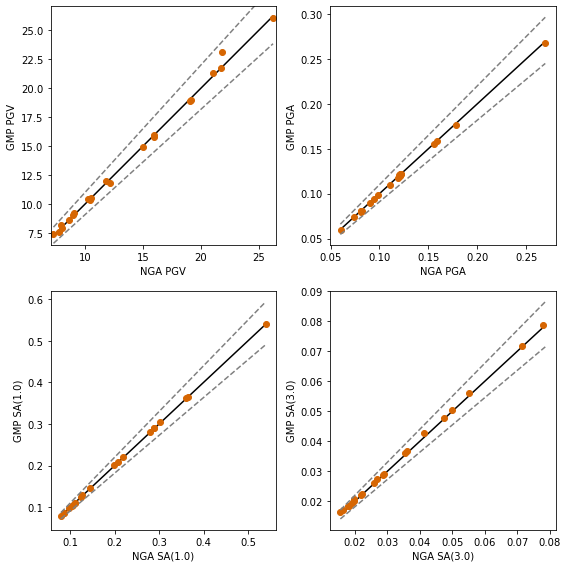

In [9]:
merge_plot(coalinga_merge)

Repeat the same steps for the Parkfield event.

In [10]:
parkfield_nga_id = 179
parkfield_comcat_id = 'nc30228270'
parkfield_merge = get_merge_frame(nga_frame, gmp_frame,
                               parkfield_nga_id,
                               parkfield_comcat_id)
parkfield_merge.head()

,StationCode,PGA (g),PGV (cm/sec),T1.000S,T3.000S,PGA,PGV,SA(1.000),SA(3.000)
0,35219,0.007896,1.23600,0.017601,0.002215,0.791588,1.231021,1.773088,0.224552
1,36153,0.016297,0.72954,0.009938,0.001041,1.619977,0.737952,1.003115,0.106755
2,36227,0.233240,14.96600,0.142132,0.013038,23.323336,14.847198,14.308654,1.354005
3,36427,0.010926,0.93901,0.011824,0.002063,1.090962,0.929237,1.195458,0.210479
4,36712,0.036384,2.43360,0.022105,0.006211,3.622751,2.435037,2.225655,0.628242


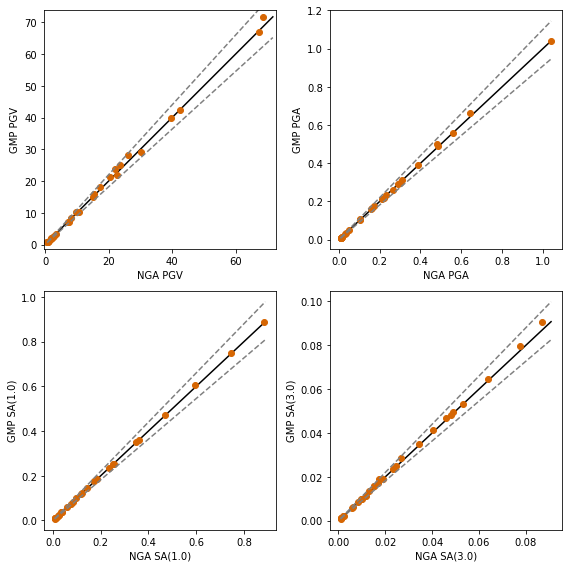

In [11]:
merge_plot(parkfield_merge)